# 공정성

## 목표

* 모델 데이터에서 나타날 수 있는 여러 유형의 편향에 대한 이해도 제고
* 모델을 학습시키기 전에 특성 데이터를 살펴보고 잠재적 데이터 편향 요인을 미리 파악
* 종합집계하는 대신 하위 그룹으로 묶어 모델 성능을 평가

## 개요

머신러닝(ML)에 원치 않는 편향이 발생할 수 있는 방식에 주목하면서 *공정성*을 염두에 두고 데이터세트를 살펴보고 분류자를 평가

공정성에 관한 ML 프로세스의 컨텍스트를 구성할 기회를 제공하는 **Fairness** 작업을 확인. 작업을 진행하는 동안 편향을 파악하고, 이러한 편향이 해결되지 않을 때 발생하는 모델 예측의 장기적인 영향을 고려

## 데이터세트 및 Prediction 작업 정보
서울대학교 보건 데이터셋을 활용

\- 원본 데이터세트에서 ML 공정성에 영향을 미칠 수 있는 field만을 임의 선택하여 학습에 사용

### Binary(이진) Features
*   `sex`: 성별
*   `cva`: 뇌졸중 과거력
*   `fcvayn`: 뇌졸중 가족력

### Numeric(수적) Features
*   `packyear`: 하루 흡연량(갑) X 흡연기간
*   `packyear`: 일주일간 음주 빈도
*   `exerfq`: 일주일간 운동한 총 일수

### Categorical(범주적) Features
*   `age`: 나이

### Prediction 작업
예측 작업은 조사 대상자의 성별을 예측하기 위해 실행

### Label
*   `sex`: 조사 대상자의 성별을 나타냄

## 공정성 지표

### 1. 균등 기회 (Equal Opportunity)

- definition: 보호 그룹과 보호되지 않은 그룹은 동일한 참긍정(True Positive)의 비율을 가져야 함
- `sex` field 에서 남녀 성별 확인을 위한 Prediction
- Category `cva` 중 Subgroup `0`(뇌졸중 과거력 있음) 입력에 따른 TPR과 Subgroup `1`(뇌졸중 과거력 없음) 입력에 따른 TPR이 같아야만 균등 기회(Equal Opportunity)를 만족

### 2. 균등 승률 (Equalized odds)

- definition: 보호된 그룹과 보호되지 않은 그룹은 참긍정(True Positive)과 오탐지(False Negative)에 대해 동일한 비율을 가져야 함
- `sex` field 에서 남녀 성별 확인을 위한 Prediction
- Category `cva` 중 Subgroup `0`(뇌졸중 과거력 있음) 입력에 따른 TPR, FPR과 Subgroup `1`(뇌졸중 과거력 없음) 입력에 따른 TPR, FPR이 같아야만 균등 승률(Equalized odds)을 만족

### 3. 인구통계패리티 (Demographic Parity)
- definition: 긍정적인 결과의 가능성은 개인이 보호된(예 : 여성) 그룹에 있는지 여부 에 관계없이 동일해야 함
- `sex` field 에서 남녀 성별 확인을 위한 Prediction
- Category `cva` 중 Subgroup `0`(뇌졸중 과거력 있음) 입력에 따른 TP+FP/TN+FN과 Subgroup `1`(뇌졸중 과거력 없음) 입력에 따른 TP+FP/TN+FN이 같아야만 인구통계패리티 (Demographic Parity)을 만족

## Dependency

In [1]:
import pandas as pd
import numpy as np
import math
import random
import tqdm
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from matplotlib import pyplot as plt
from matplotlib import rcParams

import seaborn as sns
import itertools

## Load dataset

### target
*   `sex`: 조사 대상자의 성별을 나타냄

### Subgroup
*   `cva`: 뇌졸중 과거력을 나타냄

In [2]:
train = pd.read_csv("before.csv")
train.fillna(0, inplace=True)

test = pd.read_csv('testset.csv')
test.fillna(0, inplace=True)

target = 'sex'
subgroup = 'cva'

col = list(train.columns)
except_target = col.copy()
except_target.remove(target)
lable=target
features = list(train.columns)
features.remove(lable)

In [3]:
y_train=train[lable].astype(int)
X_train=train[features].astype(int)


y_test=test[lable].astype(int)
X_test=test[features].astype(int)

CATEGORY  =  subgroup
SUBGROUP = 0 
X_test_a  = test.loc[test[CATEGORY] == SUBGROUP][features]
y_test_a  = test.loc[test[CATEGORY] == SUBGROUP][lable]

SUBGROUP = 1 
X_test_b  = test.loc[test[CATEGORY] == SUBGROUP][features]
y_test_b  = test.loc[test[CATEGORY] == SUBGROUP][lable]

## Fairness 작업 #1

* 보정 전 데이터셋를 사용하여 `SVC`, `LogisticRegression` 등 모델 학습
* 학습 결과에 따른 서브그룹별 TP, TN, FP, FN 도출 및 Confusion Matrix 시각화

In [4]:
def get_info(y_test, y_hat) : 
    
    tp = np.sum((y_test ==1) & (y_hat==1) )
    tn = np.sum((y_test ==0) & (y_hat==0) )
    fp = np.sum((y_test ==0) & (y_hat==1) )
    fn = np.sum((y_test ==1) & (y_hat==0) )
    
    accuracy = np.mean(np.equal(y_test,y_hat))
    
    return tp, tn, fp, fn, accuracy

In [5]:
def plot_confusion_matrix(TP, FN, FP, TN):
    
    confusion_matrix = np.array([[TP, FN], 
                                 [FP, TN]])
    class_names = ['cva=1', 'cva=2']          
    subgroup =  "Result"

    df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
    )

    fig = plt.figure(figsize=(8,6))

    plt.title('Confusion Matrix ' + subgroup)

    strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
    labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

    heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"))
    heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('References')
    plt.xlabel('Predictions')
    
    return fig

In [6]:
def draw_plt(TP, TN, FP, FN):
    SUBGROUP =  "Result"

    classes = ['cva=1', 'cva=2']

    confusion_matrix = np.array([[TP, FN], 
                                 [FP, TN]])

    performance_metrics = {
        'TPR=TP/(TP+FN)': TP/(TP+FN),
        'TNR=TN/(TN+FN)': TN/(TN+FP),
        'FPR=FP/(TP+FP)': FP/(FP+TN),
        'FNR=FN/(TP+FN)': FN/(TP+FN)
    }
    
    return plot_confusion_matrix(confusion_matrix, classes, SUBGROUP)

before TPRA : 0.9255729061042385/ before FPRA : 0.8147847278635256/ before DFA : 0.14913712686567165
before TPRB : 0.855072463768116/ before FPRB : 0.7105263157894737/ before DFB : 0.2831858407079646


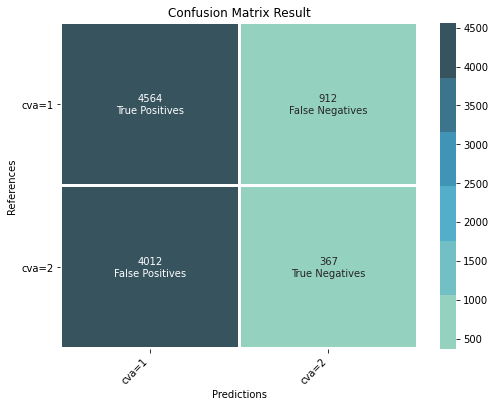

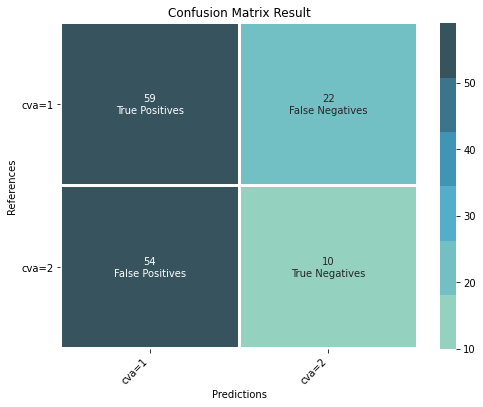

In [7]:
#model = SVC(kernel = 'rbf')
#model = SVC(C=1)
model = LogisticRegression()
model.fit(X_train, y_train)

y_hat = model.predict(X_test_a)
tp_a, tn_a, fp_a, fn_a, accuracy = get_info(y_test_a, y_hat)
before_tpr_a = tp_a/(tp_a+fn_a)
before_fpr_a = fp_a/(fp_a+tn_a)
before_dp_a = (tn_a+fn_a)/(tp_a+fp_a)

y_hat = model.predict(X_test_b)
tp_b, tn_b, fp_b, fn_b, accuracy = get_info(y_test_b, y_hat)
before_tpr_b = tp_b/(tp_b+fn_b)
before_fpr_b = fp_b/(fp_b+tn_b)
before_dp_b = (tn_b+fn_b)/(tp_b+fp_b) 

print("before TPRA : " + str(before_tpr_a) + "/ before FPRA : " + str(before_fpr_a) + "/ before DFA : " + str(before_dp_a))
print("before TPRB : " + str(before_tpr_b) + "/ before FPRB : " + str(before_fpr_b) + "/ before DFB : " + str(before_dp_b))

ax1 = plot_confusion_matrix(tp_a, tn_a,fp_a, fn_a)
ax2 = plot_confusion_matrix(tp_b, tn_b,fp_b, fn_b)

## Fairness 작업 #2

* Fairness 작업 #1에서 도출된 서브그룹 별 TPR 활용

In [8]:
def get_first_data( df, cur_col, tpra, tprb ) : 
    uniq = df[cur_col].unique()
    return_li = []
    for i in uniq : 
        return_li.append(df[df[cur_col]==i])

    arg_len = len(return_li)
    avg_ratio=abs(tpra-tprb)
    avg_fair=[]
    arg_sum = 0
    
    for i in range(arg_len) : 
        arg_sum+=len(return_li[i])
    arg_avg = arg_sum/arg_len
    
    for i in range(arg_len) : 
        if len(return_li[i])>arg_avg : 
            avg_fair.append(len(return_li[i])-(len(return_li[i])-arg_avg)*avg_ratio)
        else : avg_fair.append(len(return_li[i]))
            
    return return_li, avg_fair

In [9]:
def get_next_data( df, cur_col, ratio ) : 
    uniq = df[cur_col].unique()
    return_li = []
    for i in uniq : 
        return_li.append(df[df[cur_col]==i])
    arg_avg, avg_fair= get_avg(return_li, ratio)
    return return_li, avg_fair

def get_avg( arg, ratio ) : 
    arg_sum = 0
    arg_len = len(arg)
    avg_ratio=[]
    avg_fair=[]
    
    for i in range(arg_len) : 
        arg_sum+=(len(arg[i])*ratio)
    arg_avg = arg_sum/arg_len
        
    for i in range(arg_len) : 
        if len(arg[i])>arg_avg : 
            avg_fair.append(arg_avg)
        else : avg_fair.append(len(arg[i]))
            
    return arg_avg, avg_fair

In [10]:
def fairness(avg_fair, fair_data, col):

    tmp_fair_data=[]
    tmp_avg_li=[]

    for i,j in zip(fair_data,avg_fair) : 
        if j < len(i) : 
            ratio=1-((len(i)-j)/len(i))
        else : ratio=1
        #print(ratio)        
        return_li,avg = get_next_data(i, col, ratio)

        tmp_avg_li.append(avg)
        tmp_fair_data.append(return_li)

    tmp_fair_data=list(itertools.chain(*tmp_fair_data))
    #print(len(b))

    avg_fair=list(itertools.chain(*tmp_avg_li))
    
    return avg_fair, tmp_fair_data

In [11]:
fair_data, avg_fair = get_first_data(train, target, before_tpr_a, before_tpr_b)
for i in except_target : 
    avg_fair, fair_data = fairness(avg_fair, fair_data, i)

fair=pd.DataFrame(columns=col)
for i,j in zip(fair_data,avg_fair) :
    fair = pd.concat([i.sample(int(j)), fair])
    
fair.to_csv("after.csv", index=False)

## Fairness 작업 #3

* 검증 작업
* 보정 후 데이터셋를 사용하여 `SVC`, `LogisticRegression` 등 모델 학습
* 학습 결과에 따른 서브그룹별 TP, TN, FP, FN 도출 및 Confusion Matrix 시각화

In [12]:
fair = pd.read_csv("after.csv")

y_fair=fair[lable].astype(int)
X_fair=fair[features].astype(int)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


after TPRA : 0.9592374771851552/ after FPRA : 0.8976441917140536/ after DFA : 0.07704918032786885
after TPRB : 0.9565217391304348/ after FPRB : 0.8552631578947368/ after DFB : 0.10687022900763359


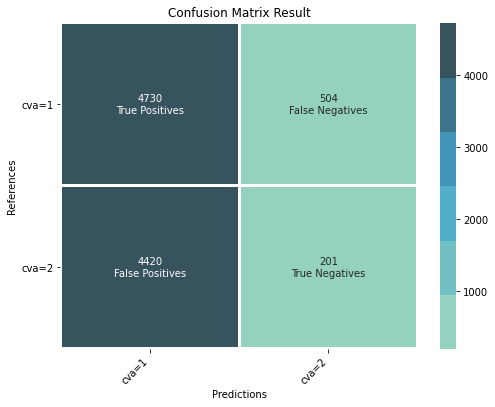

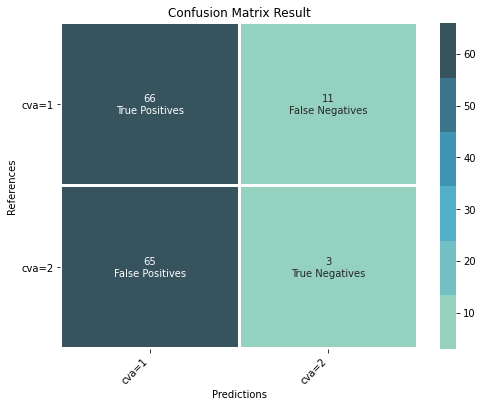

In [13]:
#model = SVC(kernel = 'rbf')
model = LogisticRegression()
#model = SVC(C=1)
model.fit(X_fair, y_fair)

y_hat = model.predict(X_test_a)
tp_a, tn_a, fp_a, fn_a, accuracy = get_info(y_test_a, y_hat)
after_tpr_a = tp_a/(tp_a+fn_a)
after_fpr_a = fp_a/(fp_a+tn_a)
after_dp_a = (tn_a+fn_a)/(tp_a+fp_a)

y_hat = model.predict(X_test_b)
tp_b, tn_b, fp_b, fn_b, accuracy = get_info(y_test_b, y_hat)
after_tpr_b = tp_b/(tp_b+fn_b)
after_fpr_b = fp_b/(fp_b+tn_b)
after_dp_b = (tn_b+fn_b)/(tp_b+fp_b)

print("after TPRA : " + str(after_tpr_a) + "/ after FPRA : " + str(after_fpr_a) + "/ after DFA : " + str(after_dp_a))
print("after TPRB : " + str(after_tpr_b) + "/ after FPRB : " + str(after_fpr_b) + "/ after DFB : " + str(after_dp_b))

ax1 = plot_confusion_matrix(tp_a, tn_a,fp_a, fn_a)
ax2 = plot_confusion_matrix(tp_b, tn_b,fp_b, fn_b)

## 지표별 보정성능 (균등 기회 - equality of opportunity)

$$ 보정성능 = (\frac{|before\_TPR\_A - before\_TPR\_B|-|after\_TPR\_A - after\_TPR\_B|}{|before\_TPR\_A - before\_TPR\_B|}) * 100 $$

In [14]:
score_TPR = (abs(before_tpr_a-before_tpr_b)-abs(after_tpr_a-after_tpr_b))/abs(before_tpr_a-before_tpr_b)
print("Equality of Opportunity : " + str(score_TPR*100) + " %")

Equality of Opportunity : 96.14791345312044 %


## 지표별 보정성능 (균등 승률 - equalized odds)

$$ 보정성능 = (\frac{(\frac{|before\_TPR\_A - before\_TPR\_B|-|after\_TPR\_A - after\_TPR\_B|}{|before\_TPR\_A - before\_TPR\_B|}) + (\frac{|before\_FPR\_A - before\_FPR\_B|-|after\_FPR\_A - after\_FPR\_B|}{|before\_FPR\_A - before\_FPR\_B|})}{2}) * 100 $$

In [15]:
score_TPRFPR = ((abs(before_tpr_a-before_tpr_b)-abs(after_tpr_a-after_tpr_b))/abs(before_tpr_a-before_tpr_b) + 
                (abs(before_fpr_a-before_fpr_b)-abs(after_fpr_a-after_fpr_b))/abs(before_fpr_a-before_fpr_b))/2
print("Equalized odds : " + str(score_TPRFPR*100) + " %")

Equalized odds : 77.74896185266233 %


## 지표별 보정성능 (인구통계 패리티 - demographic parity)

$$ 보정성능 = (\frac{|before\_DP\_A - before\_DP\_B|-|after\_DP\_A - after\_DP\_B|}{|before\_DP\_A - before\_DP\_B|}) * 100 $$

In [16]:
score_DP = (abs(before_dp_a-before_dp_b)-abs(after_dp_a-after_dp_b))/abs(before_dp_a-before_dp_b)
print("Demographic Parity : " + str(score_DP*100) + " %")

Demographic Parity : 77.75357343984 %


## 보정성능 (평균)

$$ 보정성능 = \frac{1}{n}\sum_{i=1}^n(\frac{|IFV_N-OFV_N|-|IFV_N-MFV_N|}{|IFV_N-OFV_N|}) = (\frac{균등기회보정률+균등승률보정률+인구통계패리티보정률}{3})$$ 

*   `i`: 공정성 보정지표
*   `n`: 적용한 공정성 보정지표 수
*   `IFV(Ideal Fair Value)`: 공정성 지표별 기준 값
*   `OFV(Original Fair Value)`: 보정 전 공정성 지표 값
*   `MFV(Mitigated Fiar Value)`: 보정 후 공정성 지표 값

* 출처 : 과제 RFP

In [17]:
avg_score = (score_TPR+score_TPRFPR+score_DP)/3
print("Avg : "+str(avg_score*100) + " %")

Avg : 83.88348291520758 %
